In [121]:
import pandas as pd
import quandl
import math
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import time

In [99]:
# Regression - Intro and Data
df = quandl.get('WIKI/GOOGL')

df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

In [100]:
# Regression - Features and Labels

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

In [105]:
# Regression - Training and Testing

# Remove the label column to get just the features
X = np.array(df.drop(['label'], 1))

# Scale the features between -1 and 1
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

# Drop all NA values in original dataframe
df.dropna(inplace=True)

# Set y to the value of the labels
y = np.array(df['label'])

# Check if the dimensions of X and y match
X.shape, y.shape

# Split the training and test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

# Train the regression model
clf = LinearRegression(n_jobs=-1)
#clf = svm.SVR(kernel='poly')
clf.fit(X_train, y_train)

# Get accuracy
accuracy = clf.score(X_test, y_test)
print forecast_out, accuracy

32 0.974418828269


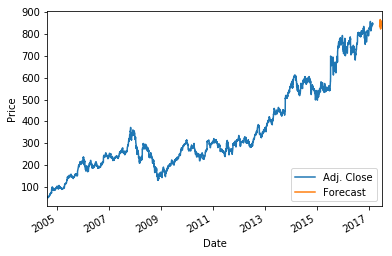

In [144]:
# Regression - Forecasting and Predicting

# Get predictions
forecast_set = clf.predict(X_lately)

# Create forecast chart
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
#last_unix = last_date.value
last_unix = time.mktime(last_date.to_datetime().timetuple())
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    # np.nan for forecast features + forecast label
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [143]:
# Pickling and Scaling

import pickle

# Serialize
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)
    
# Load pickle
# Run the previous cell after running this to test if the pickling was successful
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)